In [2]:
import MDAnalysis as mda
import prolif as plf
from rdkit import Chem

# explicit methods

In [3]:
data_path = "../../prolif/data/implicitHbond/1s2g__1__1.A_2.C__1.D"
protein_path = f"{data_path}/receptor_ph7_amber2.pdb"
u = mda.Universe(protein_path)
protein_mol = plf.Molecule.from_mda(u)
protein_mol.n_residues

332

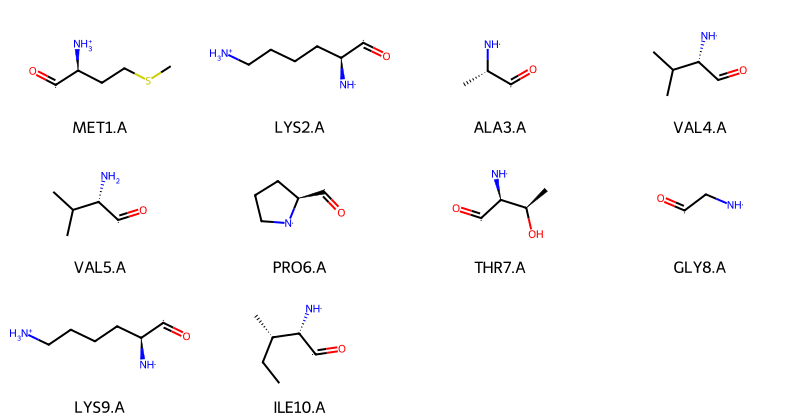

In [4]:
# check that residues 260 to 262 were processed correctly
# remove the `slice(260, 263)` part to show all residues
plf.display_residues(protein_mol, slice(0, 10))

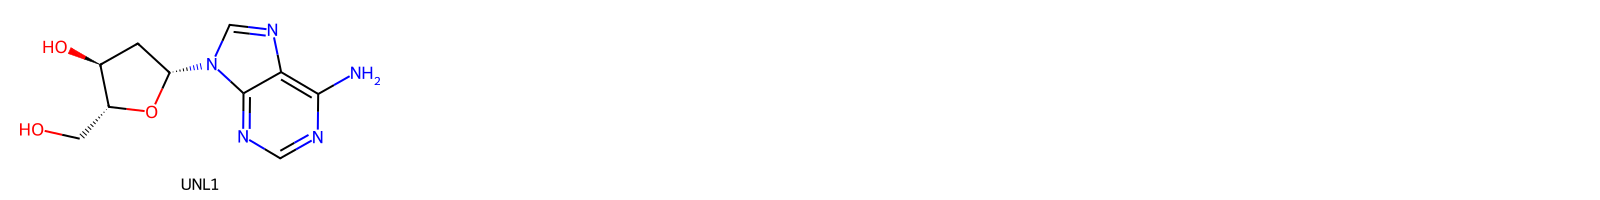

In [5]:
supplier = plf.sdf_supplier(f"{data_path}/ligand_files/1.D_protonated.sdf")
ligand = supplier[0]
plf.display_residues(ligand, size=(400, 200))

In [6]:
plf.Fingerprint.list_available()

['Anionic',
 'CationPi',
 'Cationic',
 'EdgeToFace',
 'FaceToFace',
 'HBAcceptor',
 'HBDonor',
 'Hydrophobic',
 'MetalAcceptor',
 'MetalDonor',
 'PiCation',
 'PiStacking',
 'VdWContact',
 'XBAcceptor',
 'XBDonor']

In [7]:
# use default interactions
fp = plf.Fingerprint()
# run on your poses
fp.run_from_iterable([ligand], protein_mol)

  0%|          | 0/1 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBDonor', 'HBAcceptor', 'PiStacking', 'Anionic', 'Cationic', 'CationPi', 'PiCation', 'VdWContact'] at 0x7f2330a1cd10>

In [8]:
df = fp.to_dataframe()
df.T

Frame                           0
ligand protein  interaction      
UNL1   TYR11.A  VdWContact   True
       GLY13.A  VdWContact   True
       SER14.A  HBAcceptor   True
                VdWContact   True
       TYR17.A  HBDonor      True
                VdWContact   True
       PRO44.A  Hydrophobic  True
                VdWContact   True
       PHE45.A  Hydrophobic  True
       TRP67.A  Hydrophobic  True
       THR71.A  Hydrophobic  True
       ASP75.A  VdWContact   True
       ASP95.A  VdWContact   True
       GLU101.A VdWContact   True
       ASN128.B VdWContact   True
       LEU129.B Hydrophobic  True
       MET130.B Hydrophobic  True
                VdWContact   True
       TYR167.B HBDonor      True
                VdWContact   True

In [9]:
view = fp.plot_lignetwork(ligand, kind="frame", frame=0)
view

In [10]:
fp_count = plf.Fingerprint(count=True)
fp_count.run_from_iterable([ligand], protein_mol)
view = fp_count.plot_lignetwork(ligand, kind="frame", frame=0, display_all=True)
view

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
view = fp_count.plot_3d(ligand, protein_mol, frame=0, display_all=False)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# implicit method

In [13]:
from prolif.protein_helper import ProteinHelper
from prolif.molecule import Molecule

protein_path = f"{data_path}/receptor.pdb"
# protein_helper = ProteinHelper(input_pdb_path=protein_path)
# protein_helper.standardize_protein()
input_protein_top = Chem.MolFromPDBFile(protein_path, removeHs=False)
# input_protein_top = mda.Universe(protein_path)
protein_mol = Molecule.from_rdkit(input_protein_top)

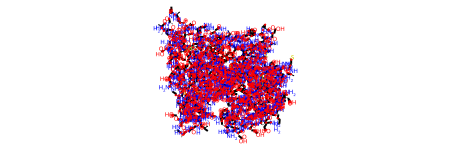

In [14]:
input_protein_top

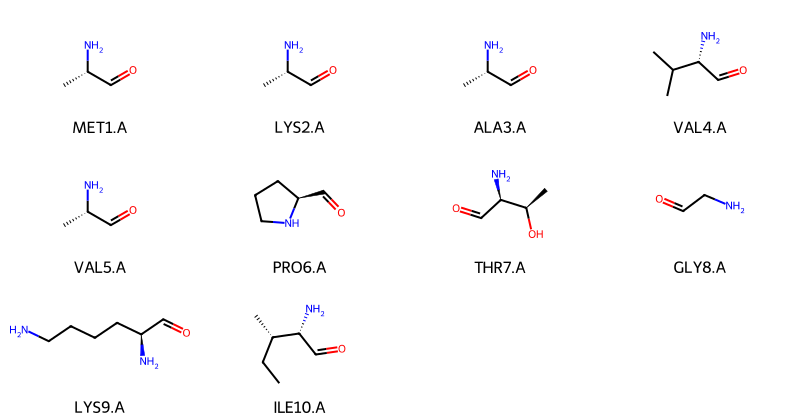

In [18]:
plf.display_residues(protein_mol, slice(0, 10))